# Review Data EDA

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from glob import glob

import seaborn as sns
sns.set()

In [2]:
def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text))

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib
font = {'size' : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)
DO_WRITE_CHARTS = True

# Load Review Data for Arizona Restaurants

In [4]:
time_marker(text='Loading Review Data...')

reviews = pd.DataFrame()
file_path_slug = '../clean_data/az_restaurant_reviews.csv'
file_list = glob(file_path_slug)

# Chunk Settings
chunks = list()
chunksize = 10000
for ii, file in enumerate(sorted(file_list)):
    time_marker('Reading {} of {} {}...'.format(ii+1, len(file_list), file))
    # import file in chunks
    for jj, chunk in enumerate(pd.read_csv(file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['date'])):
        
        # append chunk to chunks list
        chunks.append(chunk)
        
time_marker(text='merging to dataframe...')
reviews = pd.concat(chunks)

time_marker('reseting index...')
reviews.reset_index(inplace=True, drop=True)
time_marker(text='Complete!')


[10:08:06.317550] Loading Review Data...
[10:08:06.318850] Reading 1 of 1 ../clean_data/az_restaurant_reviews.csv...
[10:08:14.440540] merging to dataframe...
[10:08:15.536654] reseting index...
[10:08:15.546320] Complete!


In [5]:
time_marker('Dropping records with NaN values...')
reviews.dropna(how='any', inplace=True)
reviews.reset_index(inplace=True, drop=True)

time_marker('Cleaning data types...')
reviews['cool'] = reviews['cool'].astype('int')
reviews['funny'] = reviews['funny'].astype('int')
reviews['stars'] = reviews['stars'].astype('int')
reviews['useful'] = reviews['useful'].astype('int')
reviews['review_len'] = reviews['review_len'].astype('int')
reviews['is_fast_food'] = reviews['is_fast_food'].apply(lambda x: True if x == 1 else False)
reviews['date'] = pd.to_datetime(reviews['date'])

time_marker('assiging \'Positive\' or \'Negative\' classification to reviews...')
reviews['is_positive'] = reviews.stars.apply(lambda x: True if x > 3 else False)
           

[10:08:15.581065] Dropping records with NaN values...
[10:08:16.359195] Cleaning data types...
[10:08:16.917384] assiging 'Positive' or 'Negative' classification to reviews...


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495893 entries, 0 to 495892
Data columns (total 12 columns):
business_id     495893 non-null object
cool            495893 non-null int64
date            495893 non-null datetime64[ns]
funny           495893 non-null int64
review_id       495893 non-null object
stars           495893 non-null int64
text            495893 non-null object
useful          495893 non-null int64
user_id         495893 non-null object
is_fast_food    495893 non-null bool
review_len      495893 non-null int64
is_positive     495893 non-null bool
dtypes: bool(2), datetime64[ns](1), int64(5), object(4)
memory usage: 38.8+ MB


In [7]:
reviews.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,is_fast_food,review_len,is_positive
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,BF0ANB54sc_f-3_howQBCg,1,we always go to the chevo's in chandler which ...,3,ssuXFjkH4neiBgwv-oN4IA,False,422,False
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,DbLUpPT61ykLTakknCF9CQ,1,this place is always so dirty and grimy been t...,6,ssuXFjkH4neiBgwv-oN4IA,False,111,False
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,z_mVLygzPn8uHp63SSCErw,4,holy portion sizes! you get a lot of bang for ...,0,MzEnYCyZlRYQRISNMXTWIg,False,130,True


# Normalizing Review Text

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [9]:
# import stop words
stop_words = set(stopwords.words('english'))

# terms and characters to ignore, we dont care about punctuation
exclude = set(string.punctuation)

contractions = ["'s", "n't", "'ll", "'t", "'s", "'re"]

# lemma
lemma = WordNetLemmatizer()

exclusion_terms = list(set(set(stop_words) | set(exclude) | set(contractions)))

In [10]:
def clean_review(doc):
    ''' remove stop words, remove punctuation, and lemmatize a text document'''

    # lemmatize, tokenize and remove stop words, puncuation and contractions
    # remove non alpha tokens
    tokens = [lemma.lemmatize(word) for word in word_tokenize(doc) if word not in exclusion_terms and word.isalpha()]
    
    return tokens

# Prepare Review Corpus for LDA

In [11]:
from gensim.corpora.dictionary import Dictionary
from collections import defaultdict
import itertools

In [12]:
def lda_prep(corpus=None, n_terms=5):
    '''
    
        @ params:
            corpus   : a list of 
            n_terms  : the number of top terms to preview to the console
    
        returns:
            a list of 3 items
                dictionary        :  a gensim dictionary object built from the corpus
                corpus            :  a bag of words sparce array of corpus terms
                total_word_count  :  a defaultdict with key word identifier in dictionary, and value the count of times that word appears in the corpus
    
    '''
    if corpus == None:
        return False  
    else:
        time_marker('building gensim dict...')
        # build gensim dict, key=token, value=count
        dictionary = Dictionary(corpus)
        # print('dictionary Tokens to ID {}'.format(dictionary.token2id))

        # create a gensim corpus
        time_marker('building gensim corpus...')
        corpus = [dictionary.doc2bow(doc) for doc in clean_docs]
        # print('gensim Corpus {}'.format(corpus[0]))

        # create a defaultdict
        total_word_count = defaultdict(int)

        # loop over corpus and count the number of times each word appears
        for word_id, word_count in itertools.chain.from_iterable(corpus):
            total_word_count[word_id] += word_count

        # create a sorted list from the defaultdict
        sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)

        # print top n_terms words across all documents
        print('Top {:d} words across all documents'.format(n_terms))
        for word_id, word_count in sorted_word_count[:n_terms]:
            print('{:20}{}'.format(dictionary.get(word_id), word_count))
        
        return [dictionary, corpus, total_word_count]

# Split up by `Fast Food` and `Non Fast Food` Restaurant Reviews

In [13]:
ff_reviews = reviews[reviews.is_fast_food == True].copy()
ff_reviews.reset_index(inplace=True, drop=True)
nff_reviews = reviews[reviews.is_fast_food == False].copy()
nff_reviews.reset_index(inplace=True, drop=True)

In [14]:
print('================================= All Reviews =================================')
print('{:45}{:d}'.format('Total Number of Reviews', reviews.shape[0]))

print('============================== Fast Food Reviews ==============================')
print('{:45}{:d}\t{:2.4f}'.format('Number of Fast Food Reviews', ff_reviews.shape[0], 100.*ff_reviews.shape[0] / reviews.shape[0]))
print('{:45}{:d}\t{:2.4f}'.format('Number of Positive Fast Food Reviews', ff_reviews[ff_reviews.is_positive == True].shape[0], (100.*ff_reviews[ff_reviews.is_positive == True].shape[0]/ff_reviews.shape[0])))
print('{:45}{:d}\t{:2.4f}'.format('Number of Negative Fast Food Reviews', ff_reviews[ff_reviews.is_positive == False].shape[0], (100.*ff_reviews[ff_reviews.is_positive == False].shape[0]/ff_reviews.shape[0])))

print()
print('============================ Non Fast Food Reviews ============================')
print('{:45}{:d}\t{:2.4f}'.format('Number of Non Fast Food Reviews', nff_reviews.shape[0], 100.*nff_reviews.shape[0] / reviews.shape[0]))
print('{:45}{:d}\t{:2.4f}'.format('Number of Positive Non Fast Food Reviews', nff_reviews[nff_reviews.is_positive == True].shape[0], (100.*nff_reviews[nff_reviews.is_positive == True].shape[0]/nff_reviews.shape[0])))
print('{:45}{:d}\t{:2.4f}'.format('Number of Negative Non Fast Food Reviews', nff_reviews[nff_reviews.is_positive == False].shape[0], (100.*nff_reviews[nff_reviews.is_positive == False].shape[0]/nff_reviews.shape[0])))

================================= All Reviews =================================
Total Number of Reviews                      495893
============================== Fast Food Reviews ==============================
Number of Fast Food Reviews                  39907	8.0475
Number of Positive Fast Food Reviews         19488	48.8335
Number of Negative Fast Food Reviews         20419	51.1665

============================ Non Fast Food Reviews ============================
Number of Non Fast Food Reviews              455986	91.9525
Number of Positive Non Fast Food Reviews     303285	66.5119
Number of Negative Non Fast Food Reviews     152701	33.4881


# Reviews - Nouns & Verbs Only

<p><b>Step 1: </b>Subset to only evaluate All Reviews, but subset tokens to inlcude only nouns</p>

In [15]:
reviews.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,is_fast_food,review_len,is_positive
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,BF0ANB54sc_f-3_howQBCg,1,we always go to the chevo's in chandler which ...,3,ssuXFjkH4neiBgwv-oN4IA,False,422,False
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,DbLUpPT61ykLTakknCF9CQ,1,this place is always so dirty and grimy been t...,6,ssuXFjkH4neiBgwv-oN4IA,False,111,False
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,z_mVLygzPn8uHp63SSCErw,4,holy portion sizes! you get a lot of bang for ...,0,MzEnYCyZlRYQRISNMXTWIg,False,130,True


In [16]:
reviews.shape[0]

495893

<p><b>Step 2: </b>Tokenize and Normalize review text</p>

In [17]:
time_marker('tokenizing and normalizing text...')
reviews['tokens'] = reviews.text.apply(lambda r: clean_review(r))
reviews['norm_text'] = reviews.tokens.apply(lambda t: ' '.join(t))
time_marker('done!')

[10:08:19.745080] tokenizing and normalizing text...
[10:27:56.071784] done!


# Select only Noun Tokens
<p>Use SpaCy to generate list of unique noun tokens, then create a subset of only noun tokens for each review.</p>


# Strip down to top 10,000 most frequent tokens - Nouns & Verbs Only
<p>Well not exactly top 10,000 keep terms that appear more frequently than the 10,000th term does.</p>

In [18]:
reviews.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,is_fast_food,review_len,is_positive,tokens,norm_text
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,BF0ANB54sc_f-3_howQBCg,1,we always go to the chevo's in chandler which ...,3,ssuXFjkH4neiBgwv-oN4IA,False,422,False,"[always, go, chevo, chandler, delicious, one, ...",always go chevo chandler delicious one ahwatuk...
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,DbLUpPT61ykLTakknCF9CQ,1,this place is always so dirty and grimy been t...,6,ssuXFjkH4neiBgwv-oN4IA,False,111,False,"[place, always, dirty, grimy, twice, back, cus...",place always dirty grimy twice back customer s...
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,z_mVLygzPn8uHp63SSCErw,4,holy portion sizes! you get a lot of bang for ...,0,MzEnYCyZlRYQRISNMXTWIg,False,130,True,"[holy, portion, size, get, lot, bang, buck, se...",holy portion size get lot bang buck service su...


In [19]:
from collections import Counter

In [20]:
# list of token lists
token_lists = list(reviews['tokens'].values)

# flatten list of lists to single master list of all tokens
all_tokens_flat_list = [item for sublist in token_lists for item in sublist]

# Count occurances of each unique token, return list of unique tokens
token_counter = Counter(all_tokens_flat_list)
unique_tokens = token_counter.keys()


In [21]:
print('Number of Unique Tokens {:d}'.format(len(unique_tokens)))

Number of Unique Tokens 112123


### Get list of Unique Nouns & Verbs
<p>use SpaCy to extract only unique nouns from list of all unique tokens</p>

In [22]:
import spacy
NLP = spacy.load('en')

In [23]:
time_marker('crating merged doc from unique_tokens')
doc = ' '.join(unique_tokens)
time_marker('done')

[10:28:07.551891] crating merged doc from unique_tokens
[10:28:07.804377] done


In [24]:
time_marker('processing doc')
unique_tokens_doc = NLP(doc)
time_marker('done')

[10:28:07.846597] processing doc
[10:33:50.677289] done


In [40]:
# subset flat list to include only nouns
time_marker('extracting only nouns')
pos_filter = ['NOUN', 'VERB']
unique_NV_tokens = [str(token) for token in unique_tokens_doc if token.pos_ in pos_filter]
time_marker('done!')

print()
print('Number of Unique Noun and Verb Tokens {:d}'.format(len(unique_NV_tokens)))

[15:52:47.995208] extracting only nouns
[15:52:48.326910] done!

Number of Unique Noun and Verb Tokens 83381


## For Each Review, make subset of `noun_verb_tokens`

### WARNING THIS TAKES ABOUT 5 HOURS

In [42]:
time_marker('selecting only nouns adn verbs from each set of review tokens')
reviews['noun_verb_tokens'] = reviews['tokens'].apply(lambda token_list: [token for token in token_list if token in unique_NV_tokens])
time_marker('done')

[15:53:25.412592] selecting only nouns adn verbs from each set of review tokens
[20:00:06.074878] done


In [43]:
reviews.head(3).transpose()

,0,1,2
business_id,JlNeaOymdVbE6_bubqjohg,0Rni7ocMC_Lg2UH0lDeKMQ,S-oLPRdhlyL5HAknBKTUcQ
cool,0,0,0
date,2014-08-09 00:00:00,2014-08-09 00:00:00,2017-11-30 00:00:00
funny,0,0,0
review_id,BF0ANB54sc_f-3_howQBCg,DbLUpPT61ykLTakknCF9CQ,z_mVLygzPn8uHp63SSCErw
stars,1,1,4
text,we always go to the chevo's in chandler which ...,this place is always so dirty and grimy been t...,holy portion sizes! you get a lot of bang for ...
useful,3,6,0
user_id,ssuXFjkH4neiBgwv-oN4IA,ssuXFjkH4neiBgwv-oN4IA,MzEnYCyZlRYQRISNMXTWIg
is_fast_food,False,False,False


In [44]:
noun_verb_token_lists = list(reviews['noun_verb_tokens'].values)
flat_noun_verb_list = [item for sublist in noun_verb_token_lists for item in sublist]
noun_verb_token_counter = Counter(flat_noun_verb_list)

In [45]:
term_keep_count = 10000

title_text = 'Reviews'

df = pd.DataFrame.from_dict(noun_verb_token_counter, orient='index').reset_index()
df.columns = ['token', 'token_count']
df.sort_values('token_count', ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)

ax = df['token_count'].plot(logy=True, figsize=FIG_SIZE, marker='.', linestyle='')
ax.set_title('Noun and Verb Token Frequency in Corpus {}'.format(title_text.title()), size=TITLE_FONT_SIZE)
ax.set_xlabel('Token', size=LABEL_FONT_SIZE)
ax.set_ylabel('Token Count', size=LABEL_FONT_SIZE)
ax.set_xticks([])

# cutoff lines
ax.axvline(term_keep_count)
ax.axhline(df.iloc[term_keep_count,1])

if DO_WRITE_CHARTS:
    plt.savefig('../charts/token_dist/tokens_count_curve_nouns_verbs_{}.png'.format(title_text.lower().replace(' ', '_')))
else:
    plt.show()
plt.close()

    
# going to drop tokens that appear fewer than 4 times
print('{:30}{:d}'.format('Original Unique Token Count', df.shape[0]))
print('{:30}{:d}'.format('Pruned Token Count', df[df.token_count > df.iloc[term_keep_count,1]].shape[0]))

noun_verb_tokens_to_keep = list(df[df.token_count > df.iloc[term_keep_count,1]].token.values)

Original Unique Token Count   83329
Pruned Token Count            9992


## Prune noun tokens not found in `noun_tokens_to_keep`

In [46]:
time_marker('selecting only most frequent nouns and verbs from each set of review noun tokens')
reviews['noun_verb_tokens_keep'] = reviews['noun_verb_tokens'].apply(lambda token_list: [token for token in token_list if token in noun_verb_tokens_to_keep])
time_marker('done')

[20:01:40.406733] selecting only most frequent nouns and verbs from each set of review noun tokens
[20:07:46.257169] done


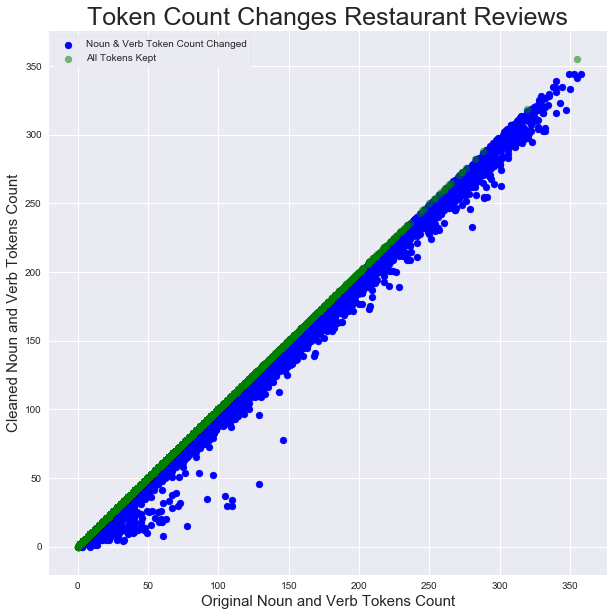

In [47]:
def plot_token_changes(df, title_text):

    diffs = df[df.noun_verb_tokens.str.len() != df.noun_verb_tokens_keep.str.len()].copy()
    origs = df[df.noun_verb_tokens.str.len() == df.noun_verb_tokens_keep.str.len()].copy()

    plt.subplots(figsize=(10, 10))
    plt.scatter(x=diffs.noun_verb_tokens.str.len(), y=diffs.noun_verb_tokens_keep.str.len(), color='b')
    plt.scatter(x=origs.noun_verb_tokens.str.len(), y=origs.noun_verb_tokens_keep.str.len(), color='g', alpha=0.5)

    plt.legend(['Noun & Verb Token Count Changed', 'All Tokens Kept'], frameon=True, loc=2)
    plt.title('Token Count Changes {}'.format(title_text.title()), size=TITLE_FONT_SIZE)
    plt.xlabel('Original Noun and Verb Tokens Count', size=LABEL_FONT_SIZE)
    plt.ylabel('Cleaned Noun and Verb Tokens Count', size=LABEL_FONT_SIZE)

    if DO_WRITE_CHARTS:
        plt.savefig('../charts/token_dist/tokens_lost_diff_noun_verb_{}.png'.format(title_text.lower().replace(' ', '_')))

    plt.show()
    plt.close()

plot_token_changes(reviews, 'Restaurant Reviews')

In [48]:
reviews.head(3).transpose()

,0,1,2
business_id,JlNeaOymdVbE6_bubqjohg,0Rni7ocMC_Lg2UH0lDeKMQ,S-oLPRdhlyL5HAknBKTUcQ
cool,0,0,0
date,2014-08-09 00:00:00,2014-08-09 00:00:00,2017-11-30 00:00:00
funny,0,0,0
review_id,BF0ANB54sc_f-3_howQBCg,DbLUpPT61ykLTakknCF9CQ,z_mVLygzPn8uHp63SSCErw
stars,1,1,4
text,we always go to the chevo's in chandler which ...,this place is always so dirty and grimy been t...,holy portion sizes! you get a lot of bang for ...
useful,3,6,0
user_id,ssuXFjkH4neiBgwv-oN4IA,ssuXFjkH4neiBgwv-oN4IA,MzEnYCyZlRYQRISNMXTWIg
is_fast_food,False,False,False


<p><b>Step 3: </b>Build our term dictionary, document term matrix, and preview the most common terms</p>

In [49]:
# collect all cleaned review strings into a list of strings
clean_docs = list(reviews.noun_verb_tokens_keep.values)

# create dictionary, corpus, and word counts with custom function
dictionary, doc_term_matrix, total_word_count = lda_prep(corpus=clean_docs, n_terms=25)

[20:07:58.706247] building gensim dict...
[20:08:32.662772] building gensim corpus...
Top 25 words across all documents
food                404223
place               321468
time                203126
service             190501
get                 154615
go                  140685
would               140516
restaurant          133011
order               131533
pizza               123077
chicken             117052
ordered             113399
u                   100542
love                96393
got                 95835
try                 87709
menu                85566
come                81478
sauce               79652
well                79116
could               78250
came                77468
salad               74661
table               72849
make                72131


<p><b>Step 4: </b>Using a Multicore LDA model, attempt to identify topics from the dictionary</p>

In [50]:
from gensim.models.ldamulticore import LdaMulticore
ldam = LdaMulticore

num_topics = 30
num_words  = 15
num_passes = 50

In [ ]:
time_marker('started generating lda multicore model')
ldam_model = ldam(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=num_passes)
time_marker('done!')

results = ldam_model.print_topics(num_topics=num_topics, num_words=num_words)

[20:47:32.649599] started generating lda multicore model


<p><b>Step 6: </b>View Results</p>

# Print Model Terms

In [ ]:
def print_topic_terms(model, num_topics=num_topics, num_words=10, unique=False):
    results = model.print_topics(num_topics=num_topics, num_words=num_words)
    if not unique:
        print('=============================== Terms Per Topic ===============================')
        for r in results:
            topic = r[0]
            term_list = r[1]

            term_list = term_list.split('"')[1::2]
            topic_terms = [term for term in term_list]
            print('{}\t{}'.format(topic, topic_terms))
    else:
        terms = [x[1] for x in results]
        term_lists = [x.split('"')[1::2] for x in terms]

        flatList = itertools.chain.from_iterable(term_lists)
        term_counts = Counter(flatList)

        # non_unique_terms = term_counts
        test = dict(term_counts)

        # extract terms that appear more than once
        non_unique_terms = [key for key, value in test.items() if value > 1]
        
        
        print('============================ Unique Terms Per Topic ===========================')
        for r in results:
            topic = r[0]
            term_list = r[1]

            term_list = term_list.split('"')[1::2]
            topic_terms = [term for term in term_list if term not in non_unique_terms]
            print('{}\t{}'.format(topic, topic_terms))

In [ ]:
print_topic_terms(ldam_model, num_topics=num_topics, num_words=10, unique=False)

In [ ]:
print_topic_terms(ldam_model, num_topics=num_topics, num_words=10, unique=True)

# Save Model

In [ ]:
# save model to disk (no need to use pickle module)
term = 'noun_verb'
file_suffix = '{}_{:d}_topics_{:d}_terms_{}_passes'.format(term, num_topics, num_words, num_passes)
ldam_model.save('../models/ldam_{}.model'.format(file_suffix))

In [ ]:
time_marker('Done!')